In [1]:
import os
adir = '../../../../data/InVivo/Seqwell/'
project_name = 'invivo_all_20200318_mmul8_V4_fixid'
gcs = False

results_dir = '../../../../results'

abase = os.path.join(adir, project_name)
abase

'../../../../data/InVivo/Seqwell/invivo_all_20200318_mmul8_V4_fixid'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.gridspec as gridspec


## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import read_adata, save_adata

sys.path.append('../../../Code/cNMF/')

from cnmf import get_highvar_genes_sparse, save_df_to_npz

import palettable
from IPython.display import display, Image

from joblib import parallel_backend


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(scanpy=True, dpi=80, vector_friendly=False, ipython_format='png')


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


## Run cNMF to facilitate estimating SOUP contribution

In [5]:
raw_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata_with_mdck = read_adata(raw_file, gcs=gcs)

Only considering the two last: ['.1', '.h5ad'].
Only considering the two last: ['.1', '.h5ad'].


In [6]:
processed_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata_annot = read_adata(processed_file, gcs=gcs)

Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [7]:
mdck_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.OnlyMDCK.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
adata_mdck = read_adata(mdck_file, gcs=gcs)

Only considering the two last: ['.OnlyMDCK', '.h5ad'].
Only considering the two last: ['.OnlyMDCK', '.h5ad'].


In [8]:
keep_cells = list(adata_annot.obs.index) + list(adata_mdck.obs.index)

In [9]:
adata_with_mdck = adata_with_mdck[keep_cells, :]

In [10]:
obs = pd.concat([adata_annot.obs, adata_mdck.obs], axis=0)
obs = obs.loc[:,adata_annot.obs.columns]

In [11]:
obs.loc[adata_mdck.obs.index, 'SubclusteringGroup'] = 'MDCK'
obs.loc[adata_mdck.obs.index, 'Subclustering_reduced'] = 'MDCK'

In [12]:
adata_with_mdck.obs = obs.loc[keep_cells, :]

In [13]:
adata_with_mdck = adata_with_mdck.copy()

In [14]:
sc.pp.filter_genes(adata_with_mdck, min_cells=10)

filtered out 273 genes that are detectedin less than 10 cells


In [16]:
pd.crosstab(adata_with_mdck.obs['Subclustering_reduced'], adata_with_mdck.obs['Period'])

Period,Baseline,Early,Late,Mid
Subclustering_reduced,,,,
B,1951,2848,6018,2688
MDCK,1195,5426,3630,2410
Mono,736,3603,1630,1007
NK,577,123,397,147
Neut,10,371,3772,1652
Plasmablast,42,53,148,23
Tc,1933,2163,3691,2495
Th,2855,4613,7323,3383
cDC,73,189,60,23


In [15]:
cnmf_dir = adir

if not os.path.exists(cnmf_dir):
    os.mkdir(cnmf_dir)
    
name = 'cNMF.{project}'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus)
count_fn = os.path.join(cnmf_dir, name+ '.SubclusterMTNKBandMDCK.h5ad')
count_fn_npz = os.path.join(cnmf_dir, name+ '.SubclusterMTNKBandMDCK.npz')

hvg_fn = os.path.join(cnmf_dir, name+ '.SubclusterMTNKBandMDCK.hvgs.txt')
print(count_fn)
print(count_fn_npz)
print(hvg_fn)

../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.SubclusterMTNKBandMDCK.h5ad
../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.SubclusterMTNKBandMDCK.npz
../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.SubclusterMTNKBandMDCK.hvgs.txt


In [16]:
sc.write(count_fn, adata_with_mdck)

Only considering the two last: ['.SubclusterMTNKBandMDCK', '.h5ad'].
Only considering the two last: ['.SubclusterMTNKBandMDCK', '.h5ad'].


... storing 'batch' as categorical
... storing 'DPIc' as categorical
... storing 'full_sample_id' as categorical
... storing 'frz_status' as categorical
... storing 'sample_source' as categorical
... storing 'sample' as categorical
... storing 'array_id' as categorical
... storing 'animal' as categorical
... storing 'full_dash_status' as categorical
... storing 'dash_status' as categorical
... storing 'sample_dash' as categorical
... storing 'Barcode' as categorical
... storing 'FullSeqRun' as categorical
... storing 'batch_short' as categorical
... storing 'leiden' as categorical
... storing 'leiden_lab_orig' as categorical
... storing 'leiden_lab_orig_group' as categorical
... storing 'leiden_lab_2' as categorical
... storing 'leiden_lab_group_2' as categorical
... storing 'SubclusteringGroup' as categorical
... storing 'Subclustering' as categorical
... storing 'Doublet' as categorical
... storing 'Subclustering_reduced' as categorical


In [17]:
X = pd.DataFrame(adata_with_mdck.X.todense(), index=adata_with_mdck.obs.index, columns=adata_with_mdck.var.index)

In [18]:

save_df_to_npz(X, count_fn_npz)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


## Picking high-variance genes excluding the cell cycle and freeze-thaw genes associated genes so they won't drive the usage inference but keeping them in the full data matrix so that their contribution will be estimated in the final set of GEPs

### This is running the cNMF hvg selection pipeline

In [19]:
sc.pp.normalize_per_cell(adata_with_mdck, counts_per_cell_after=(10**6))

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [20]:
gene_stats, _ = get_highvar_genes_sparse(adata_with_mdck.X, expected_fano_threshold=None,
                       minimal_mean=0.01, numgenes=2000)

In [21]:
hvgs = list(adata_with_mdck.var.index[gene_stats['high_var'].values])

In [22]:
open(hvg_fn, 'w').write('\n'.join(hvgs))

17106

In [23]:
numiter=20
numworkers=50
K = ' '.join([str(i) for i in range(15,30)])
seed = 14

In [24]:
## This isn't excecuting from the notebook so need to run from the shell
prepare_cmd = '/opt/miniconda3/bin/activate cnmf_env && python ../../../Code/cNMF/cnmf.py prepare --output-dir %s --name %s -c %s -k %s --n-iter %d --total-workers %d --seed %d --beta-loss frobenius --genes-file %s' % (cnmf_dir, name, count_fn_npz, K, numiter, numworkers, seed,  hvg_fn)
print(prepare_cmd)
#! {prepare_cmd}

/opt/miniconda3/bin/activate cnmf_env && python ../../../Code/cNMF/cnmf.py prepare --output-dir ../../../../data/InVivo/Seqwell/ --name cNMF.invivo_all_20200318_mmul8_V4_fixid -c ../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.SubclusterMTNKBandMDCK.npz -k 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 --n-iter 20 --total-workers 50 --seed 14 --beta-loss frobenius --genes-file ../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.SubclusterMTNKBandMDCK.hvgs.txt


In [37]:
kselect_plot_cmd = 'python ../../../Code/cNMF/cnmf.py k_selection_plot --output-dir %s --name %s' % (cnmf_dir, name)
print('K selection plot command: %s' % kselect_plot_cmd)
!{kselect_plot_cmd}

K selection plot command: python ../../../Code/cNMF/cnmf.py k_selection_plot --output-dir ../../../../data/InVivo/Seqwell/ --name cNMF.invivo_all_20200318_mmul8_V4_fixid
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].

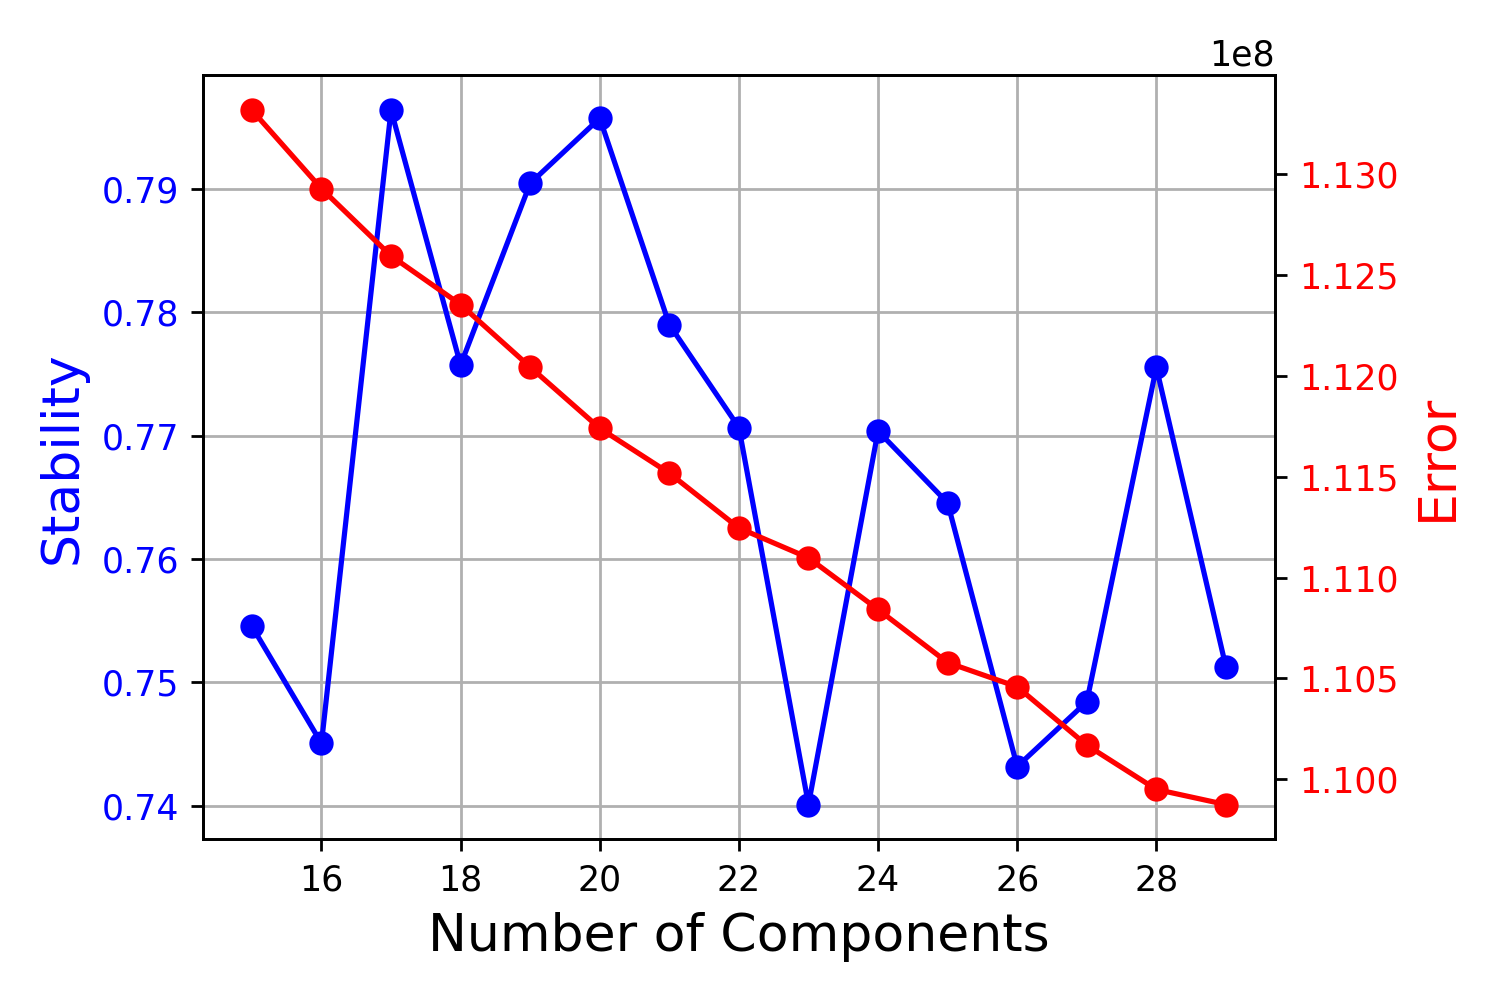

In [38]:
K_selection_plot_fn = os.path.join(cnmf_dir, name, name+'.k_selection.png')
Image(K_selection_plot_fn)

In [39]:
selected_K = 20
density_threshold = 2.00

In [40]:
consensus_cmd = 'python ../../../Code/cNMF/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (cnmf_dir, name, density_threshold, selected_K)
print('Consensus command for K=20:\n%s' % consensus_cmd)
!{consensus_cmd}

Consensus command for K=20:
python ../../../Code/cNMF/cnmf.py consensus --output-dir ../../../../data/InVivo/Seqwell/ --name cNMF.invivo_all_20200318_mmul8_V4_fixid --local-density-threshold 2.00 --components 20 --show-clustering
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'

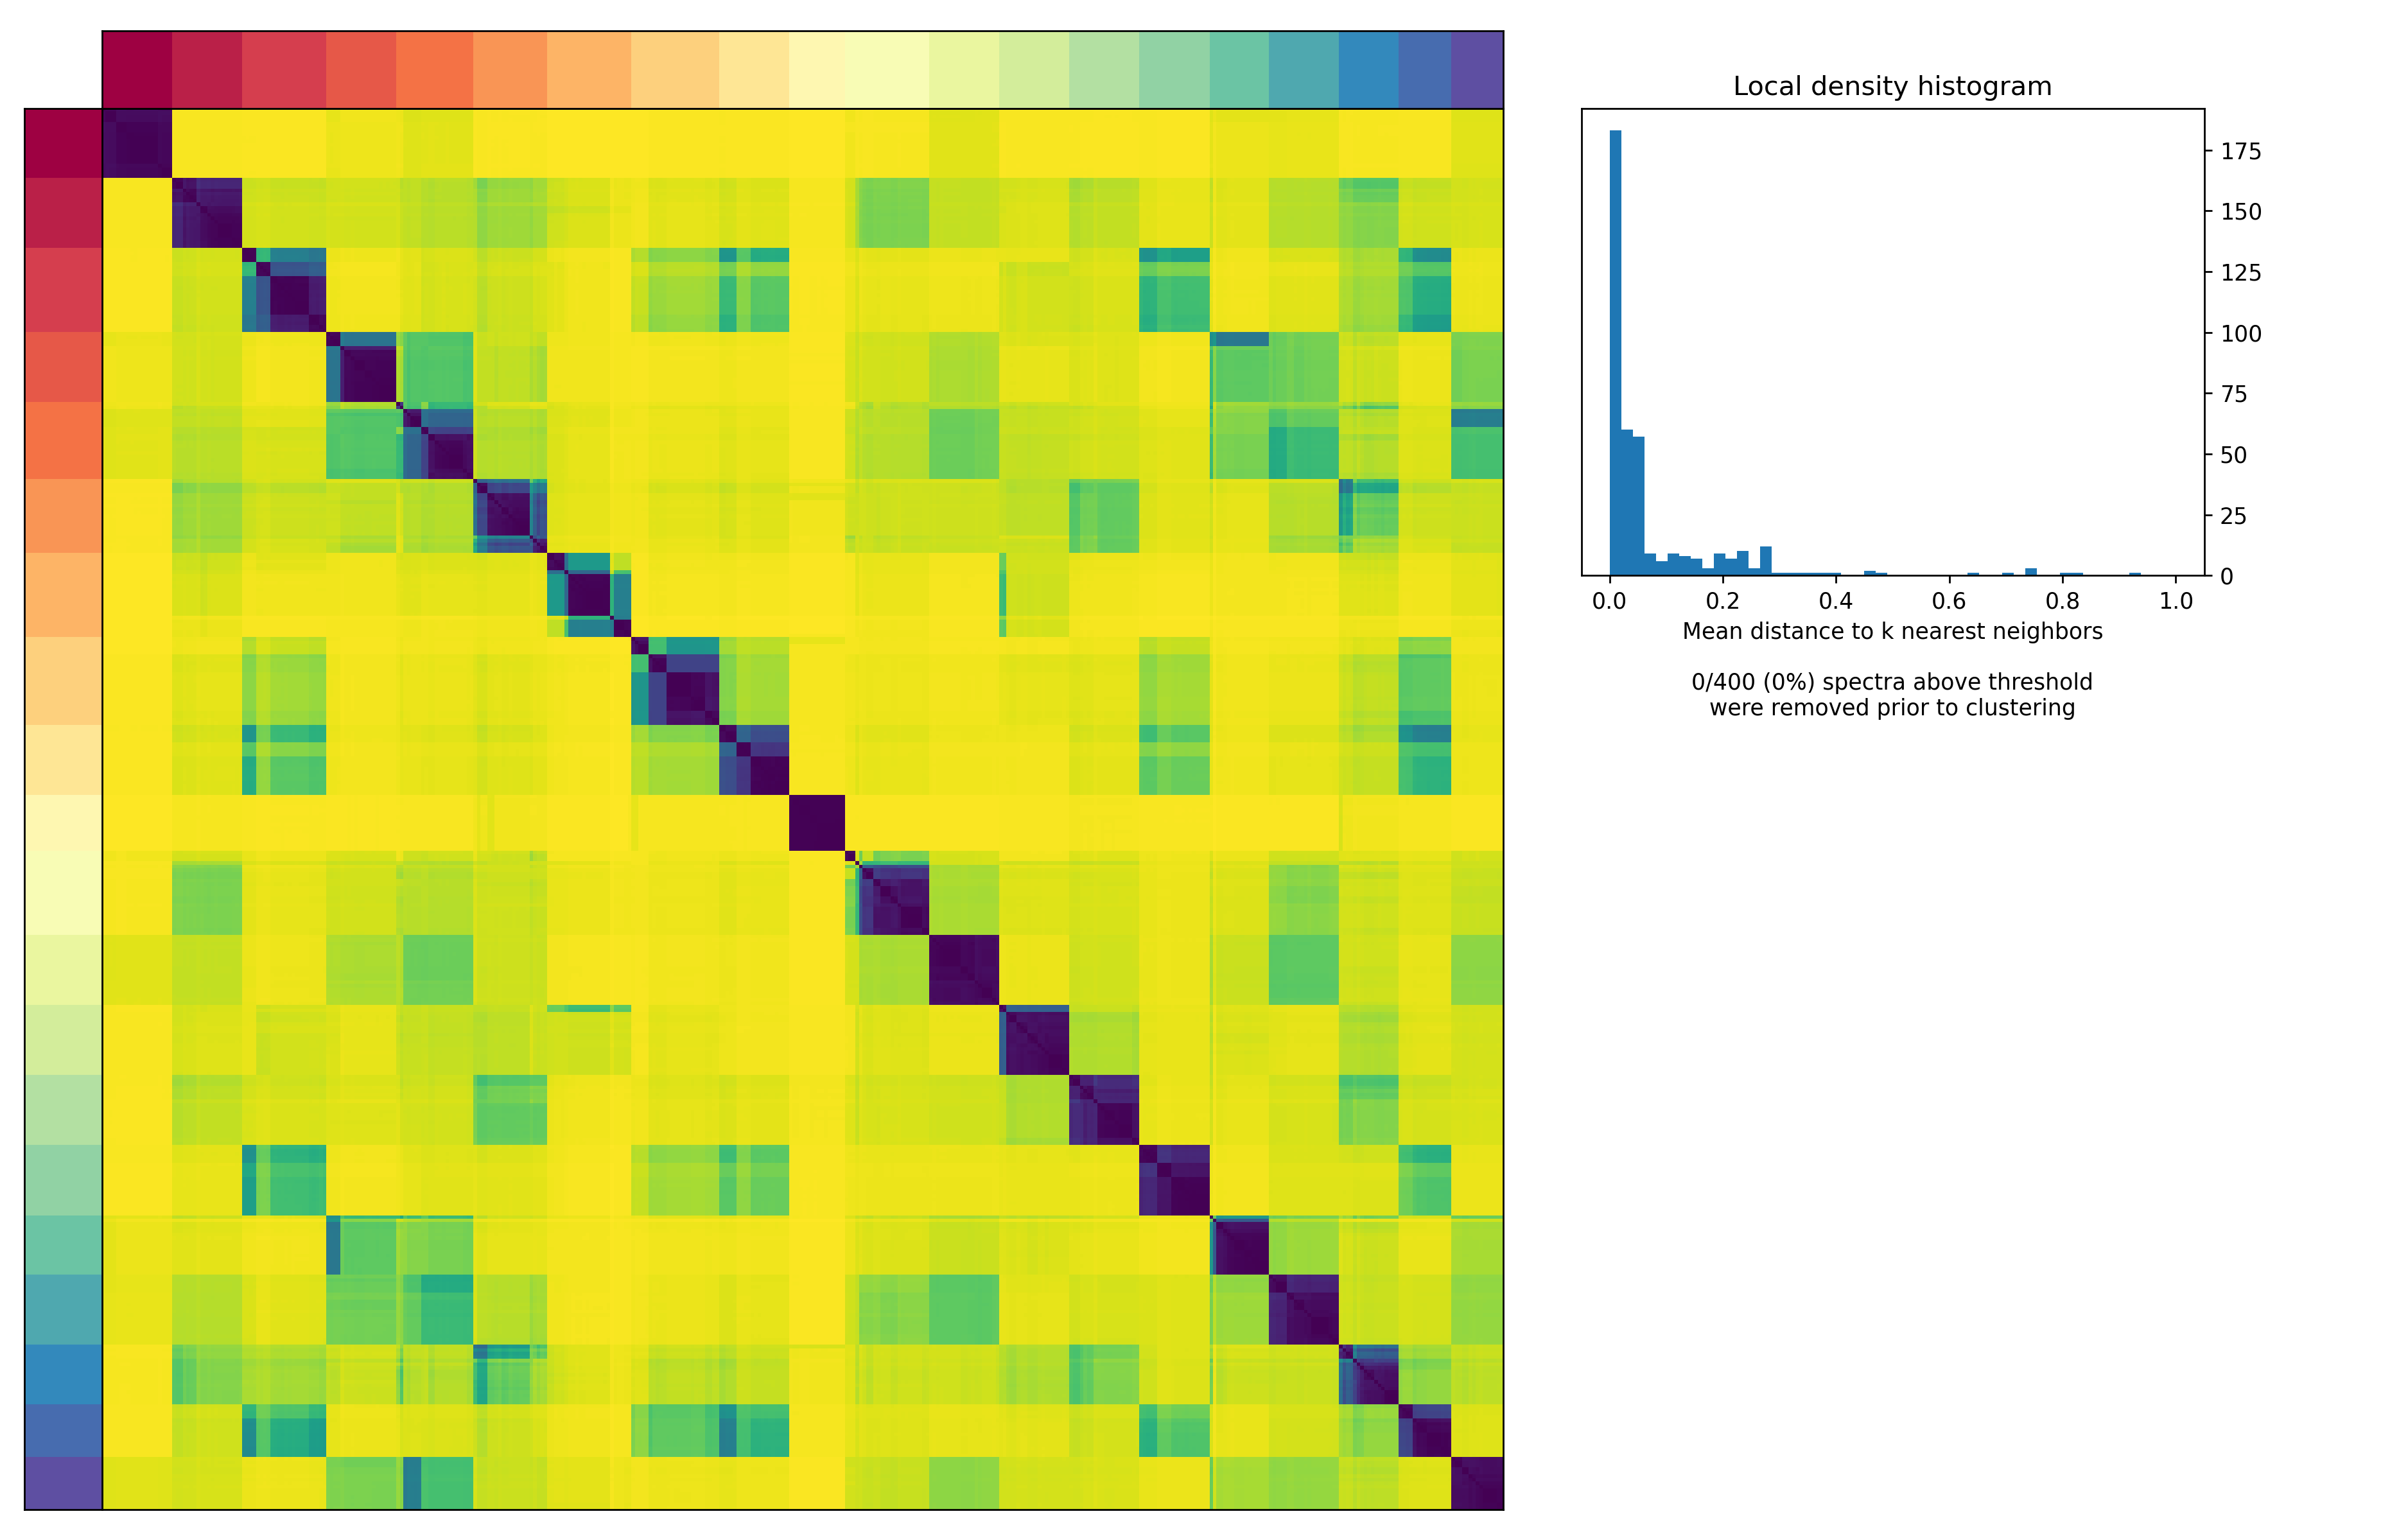

In [41]:
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')

consensus_plot_fn = os.path.join(cnmf_dir, name, name+".clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str))
Image(filename = consensus_plot_fn,
      width=1000, height=1000)

In [42]:
selected_K = 20
density_threshold = 0.10
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')


In [43]:
consensus_cmd = 'python ../../../Code/cNMF/cnmf.py consensus --output-dir %s --name %s --local-density-threshold %.2f --components %d --show-clustering' % (cnmf_dir, name, density_threshold, selected_K)
print('Consensus command for K=20:\n%s' % consensus_cmd)
!{consensus_cmd}

Consensus command for K=20:
python ../../../Code/cNMF/cnmf.py consensus --output-dir ../../../../data/InVivo/Seqwell/ --name cNMF.invivo_all_20200318_mmul8_V4_fixid --local-density-threshold 0.10 --components 20 --show-clustering
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'

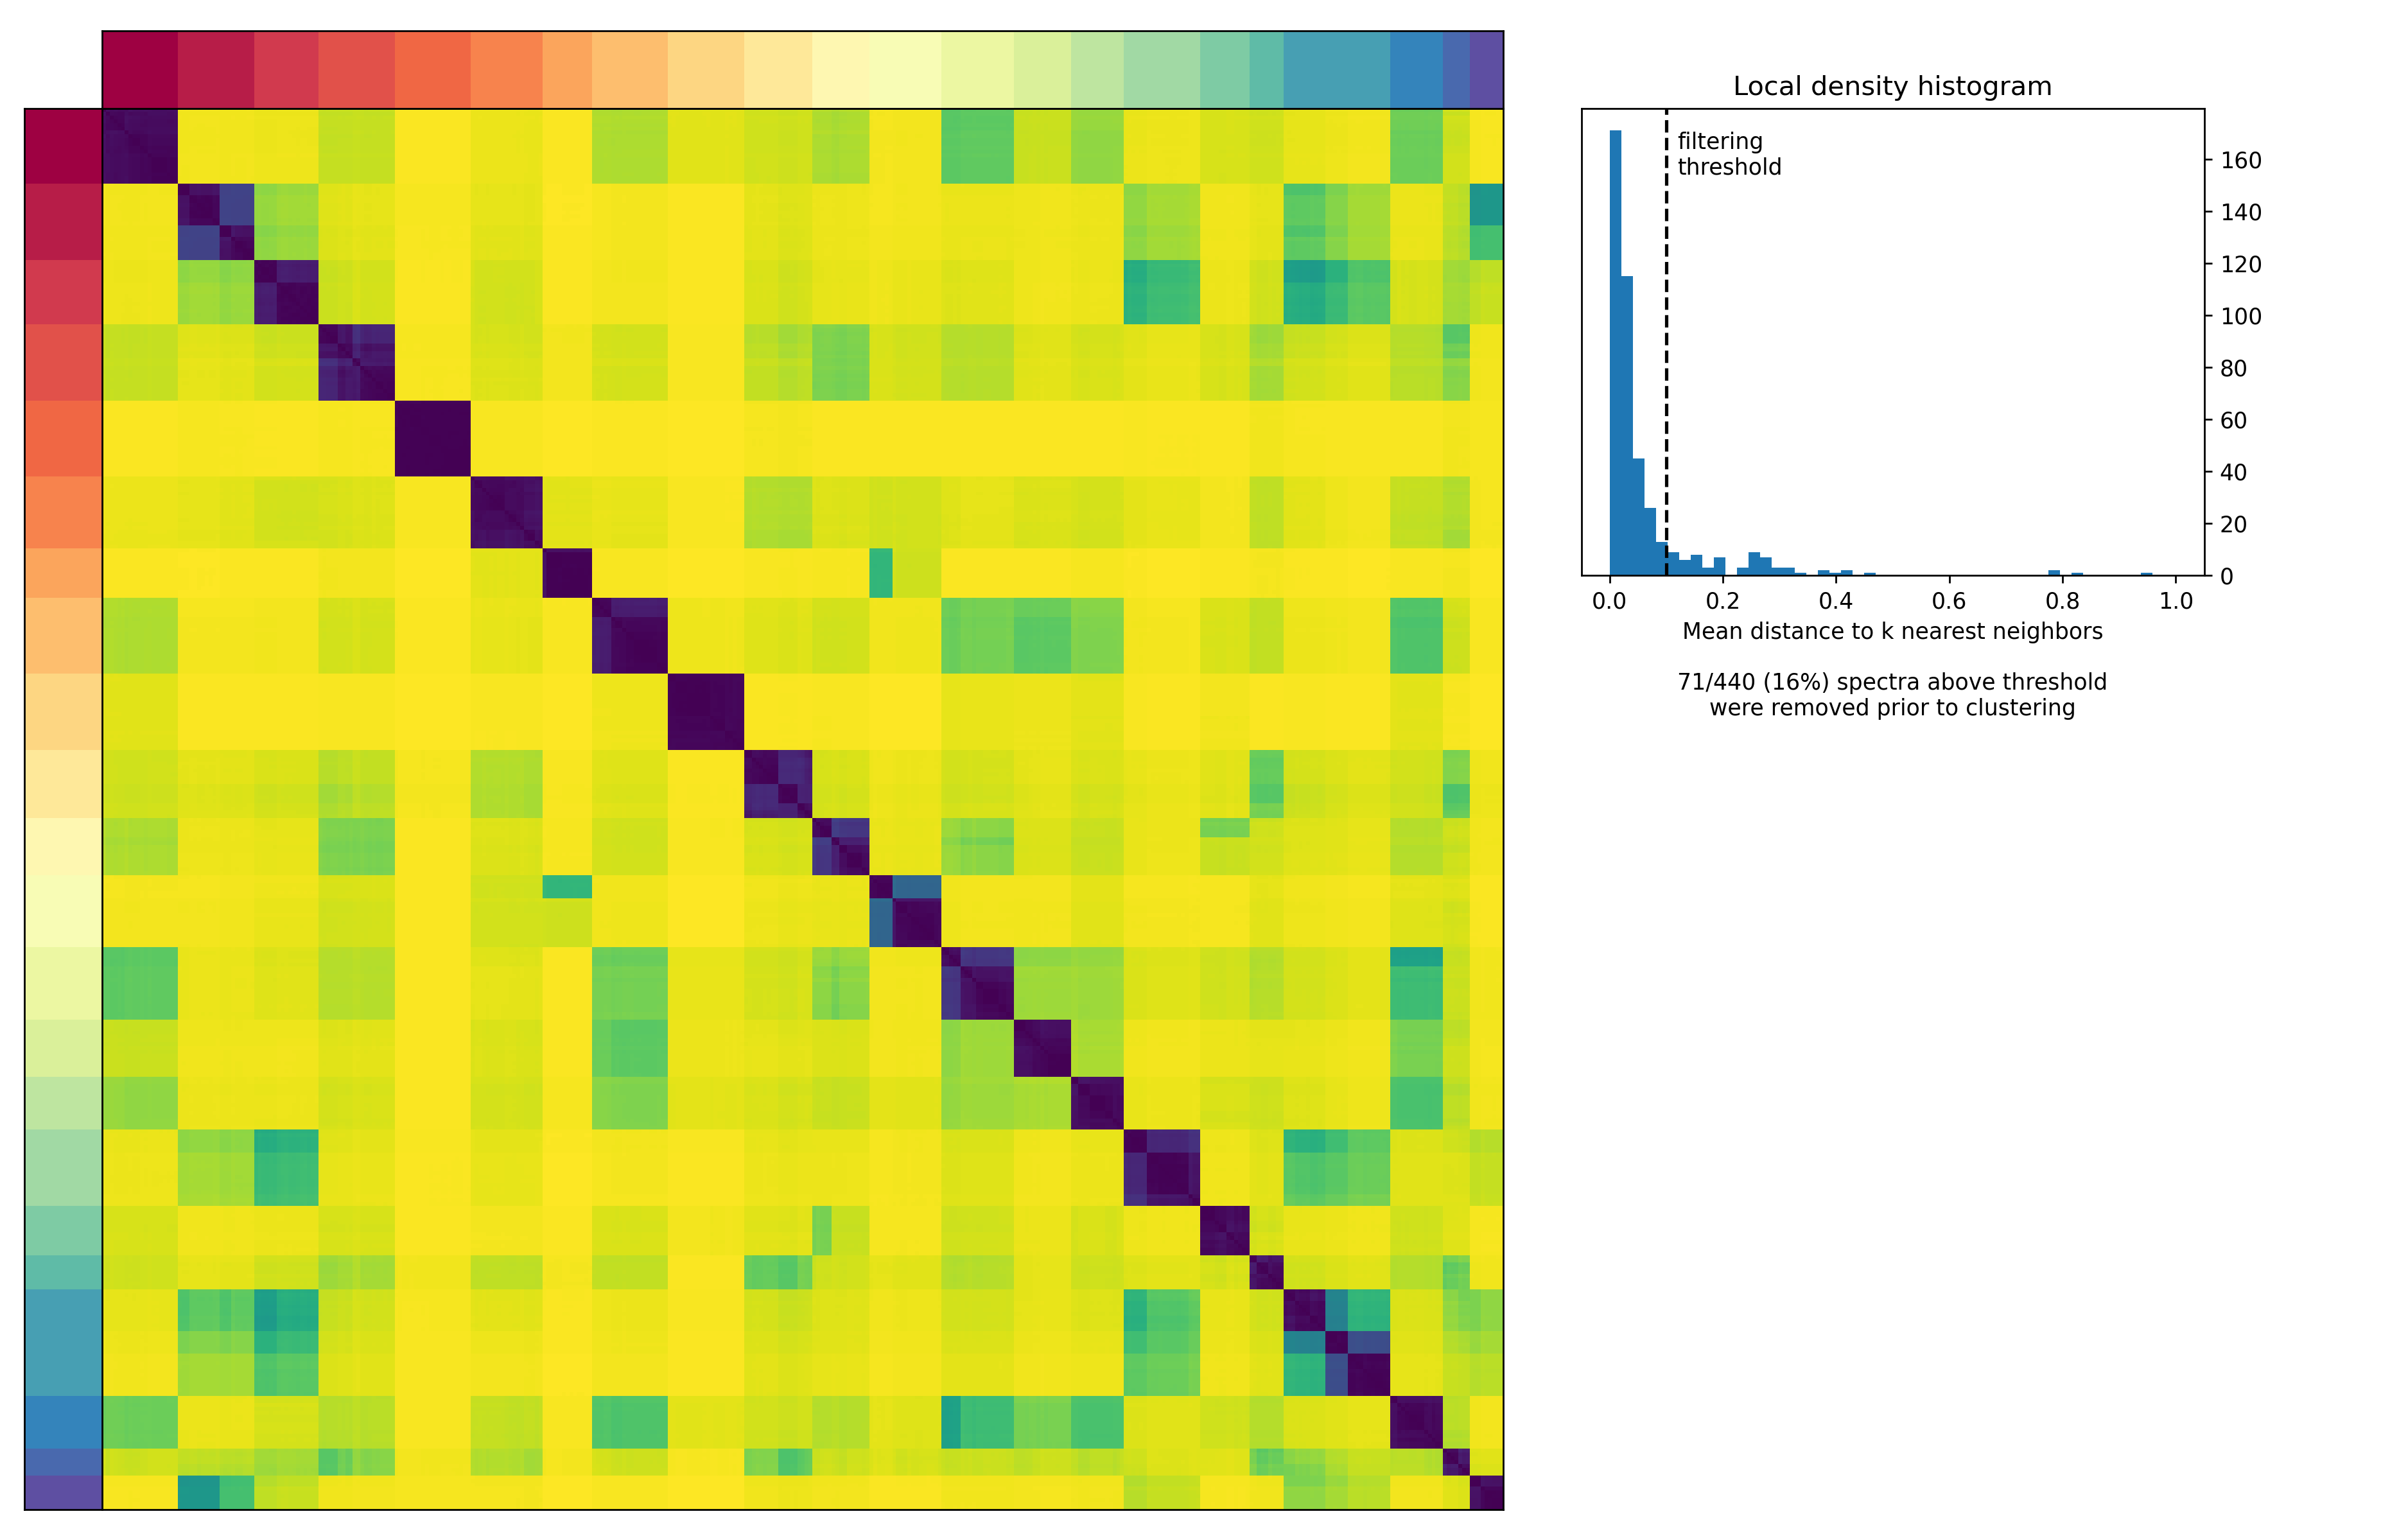

In [37]:
consensus_plot_fn = os.path.join(cnmf_dir, name, name+".clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str))
Image(filename = consensus_plot_fn,
      width=1000, height=1000)

In [44]:
usage_fn = os.path.join(cnmf_dir, name, name+".usages.k_%d.dt_%s.consensus.txt" % (selected_K, density_threshold_str))

usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

,Usage_1,Usage_2,Usage_3,Usage_4,Usage_5,Usage_6,Usage_7,Usage_8,Usage_9,Usage_10,Usage_11,Usage_12,Usage_13,Usage_14,Usage_15,Usage_16,Usage_17,Usage_18,Usage_19,Usage_20
index,,,,,,,,,,,,,,,,,,,,
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACAAGACTT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000592,0.022573,0.000000,0.298671,0.000000,0.0,0.042391,0.007364,0.0,0.582315,0.0,0.0,0.046094
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACACGCTTC,0.000000,0.020262,0.000000,0.512218,0.120726,0.006849,0.041813,0.001339,0.012242,0.000000,0.015034,0.000000,0.0,0.015910,0.000000,0.0,0.253606,0.0,0.0,0.000000
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACGAGATTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.002346,0.000000,0.000000,0.005995,0.000000,0.400420,0.000000,0.0,0.000000,0.000000,0.0,0.591239,0.0,0.0,0.000000
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG,0.006823,0.040943,0.000000,0.000000,0.068902,0.051053,0.020388,0.000000,0.000000,0.667533,0.000000,0.000000,0.0,0.000000,0.002243,0.0,0.142116,0.0,0.0,0.000000
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAATCGCTCCG,0.000000,0.000000,0.001303,0.339892,0.330898,0.009161,0.000000,0.000696,0.000000,0.000000,0.000000,0.006101,0.0,0.007923,0.001796,0.0,0.302229,0.0,0.0,0.000000


In [45]:
usage_norm.shape

(69590, 20)

In [46]:
adata_with_mdck = sc.read(count_fn)

Only considering the two last: ['.SubclusterMTNKBandMDCK', '.h5ad'].
Only considering the two last: ['.SubclusterMTNKBandMDCK', '.h5ad'].


In [47]:
adata_with_mdck

AnnData object with n_obs × n_vars = 69590 × 18032 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist'
    uns: 'DPIc_colors'

In [48]:
sc.pp.normalize_per_cell(adata_with_mdck, counts_per_cell_after=10000)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [49]:
sc.pp.log1p(adata_with_mdck)

In [50]:
sc.pp.highly_variable_genes(adata_with_mdck, n_top_genes=nhvgs)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [51]:
adata_with_mdck.var['highly_variable'].value_counts()

False    16166
True      1866
Name: highly_variable, dtype: int64

In [52]:
adata_with_mdck.raw = adata_with_mdck.copy()

In [53]:
adata_with_mdck = adata_with_mdck[:, adata_with_mdck.var['highly_variable']]
sc.pp.scale(adata_with_mdck, max_value=10)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:05)


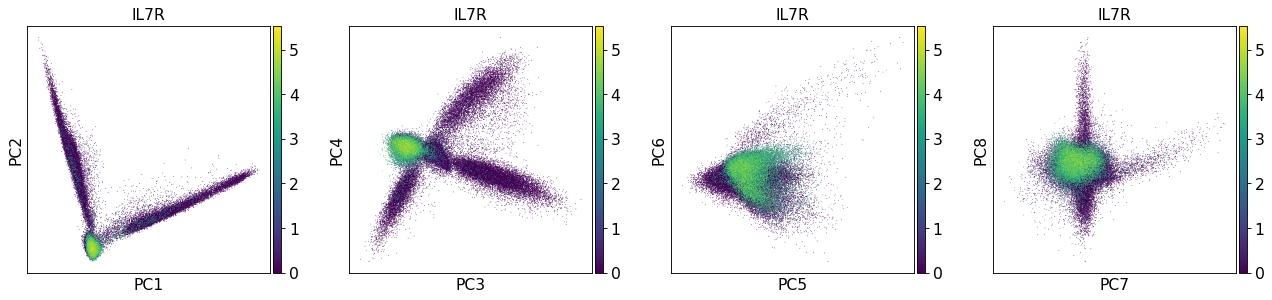

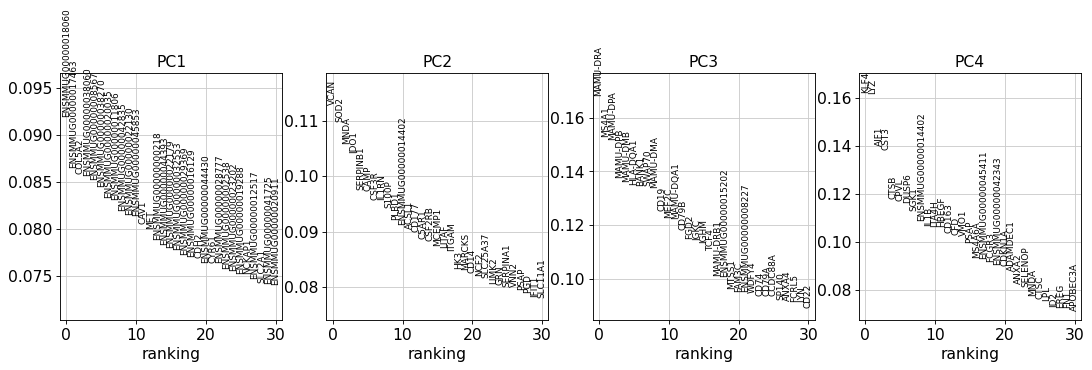

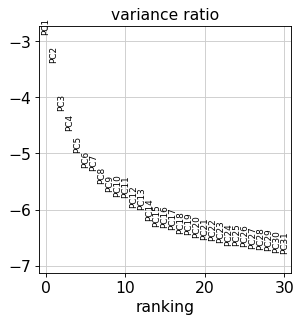

In [54]:
sc.tl.pca(adata_with_mdck, svd_solver='arpack', random_state=14)

sc.pl.pca(adata_with_mdck, components=['1,2', '3,4', '5,6', '7,8'], color=['IL7R'],
          ncols=4, use_raw=True)

sc.pl.pca_loadings(adata_with_mdck, components=[1,2,3,4])

sc.pl.pca_variance_ratio(adata_with_mdck, log=True)


In [55]:
adata_with_mdck

AnnData object with n_obs × n_vars = 69590 × 1866 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist', 'highly_variable', 'means', 'dispersion

In [56]:
with parallel_backend('threading', n_jobs=16):
    sc.pp.neighbors(adata_with_mdck, n_neighbors=int(adata_with_mdck.shape[0]*.001), n_pcs=19, random_state=14)
    
with parallel_backend('threading', n_jobs=15):
    sc.tl.umap(adata_with_mdck, min_dist=0.1, spread=2.0, random_state=14)

computing neighbors
    using 'X_pca' with n_pcs = 19


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:36)


In [57]:
adata_with_mdck.obs = pd.merge(left=adata_with_mdck.obs, right=usage_norm, how='left', left_index=True, right_index=True)

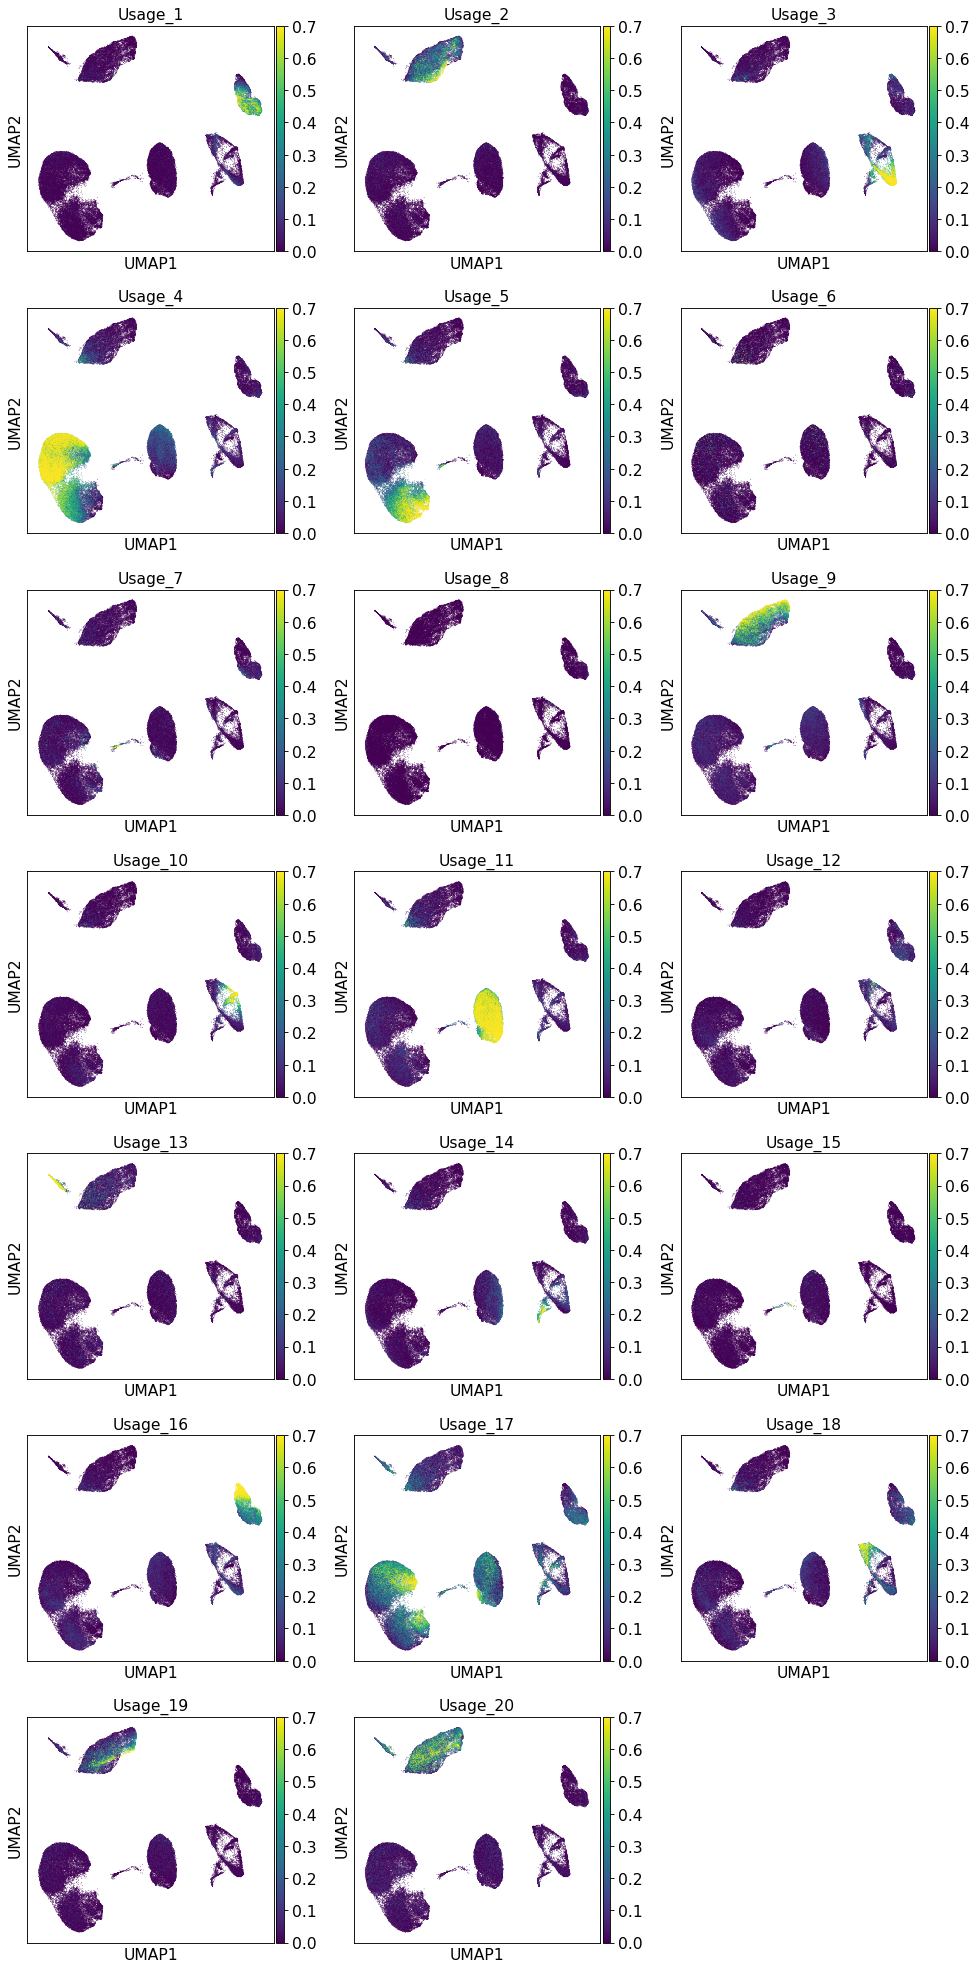

In [58]:

sc.pl.umap(adata_with_mdck, color=usage_norm.columns,
           use_raw=True, ncols=3, vmin=0, vmax=.7)

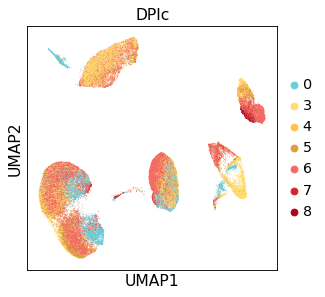

In [59]:
sc.pl.umap(adata_with_mdck, color='DPIc')

In [60]:
gene_score_fn = os.path.join(cnmf_dir, name, name+".gene_spectra_score.k_%d.dt_%s.txt" % (selected_K, density_threshold_str))
gene_scores = pd.read_csv(gene_score_fn,
                    sep='\t', index_col=0).T
gene_scores.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
EBOV-GENOME,-0.000610,0.000006,-0.000023,-0.000144,-0.000054,0.000003,0.000030,0.036057,-0.000018,-0.001020,-0.000090,-0.000626,-0.000012,0.000064,-0.000012,0.000175,0.000123,-0.000072,-0.000010,-0.000033
EBOV-GP,-0.000790,0.000012,-0.000082,-0.000230,-0.000153,-0.000019,0.000035,0.062067,-0.000024,-0.000434,-0.000141,-0.000238,-0.000018,-0.000039,-0.000005,0.000137,0.000046,-0.000168,-0.000013,-0.000050
EBOV-L,-0.000695,0.000007,-0.000017,-0.000139,-0.000085,-0.000012,0.000032,0.039530,-0.000019,-0.001097,-0.000089,-0.000743,-0.000013,0.000066,-0.000010,0.000202,0.000171,-0.000059,-0.000008,-0.000033
EBOV-NP,-0.000623,0.000006,-0.000058,-0.000185,-0.000101,0.000015,0.000029,0.044415,-0.000020,-0.000781,-0.000119,-0.000710,-0.000016,0.000041,-0.000005,0.000154,0.000106,-0.000063,-0.000011,-0.000040
EBOV-VP24,-0.000855,0.000007,-0.000050,-0.000172,-0.000102,-0.000010,0.000032,0.053608,-0.000017,-0.000925,-0.000111,-0.000837,-0.000015,0.000055,-0.000002,0.000219,0.000115,-0.000087,-0.000008,-0.000046


In [61]:
top_genes = []
ngenes = 20
for gep in gene_scores.columns:
    top_genes.append(list(gene_scores.sort_values(by=gep, ascending=False).index[:ngenes]))
    
top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
top_genes

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,LCN2,ENSMMUG00000012717,LYZ,TPT1,GZMH,ENSMMUG00000046282,ENSMMUG00000041317,EBOV-GP,ASPM,FCGR3,MS4A1,SPP1,KRT16,CPVL,JCHAIN,IFIT2,ENSMMUG00000028701,MPO,SERPINE1,DPYSL3
1,CAMP,ENSMMUG00000000347,CD163,IL7R,GZMB,ENSMMUG00000038658,ENSMMUG00000038177,EBOV-VP40,TOP2A,CFD,BANK1,CPM,TIMP3,CLEC9A,ENSMMUG00000041627,IL1RN,COX2,CLU,ENSMMUG00000044197,ANXA2
2,ENSMMUG00000031200,ENSMMUG00000007892,ENSMMUG00000014402,ZFP36L2,GNLY,PDZRN4,MKI67,EBOV-VP24,H2AFZ,SELENOP,CD19,VSIG4,KRT7,FLT3,ENSMMUG00000044136,IFIT3,UTRN,IFI27,SPARC,SLC20A1
3,MMP8,ENSMMUG00000044430,DUSP6,RPS14,HOPX,ENSMMUG00000047244,ENSMMUG00000038428,EBOV-VP30,SMC4,ENSMMUG00000045411,MAMU-DRA,CTSL,ENSMMUG00000018653,CST3,ENSMMUG00000014641,IFIT1,RNF213,ENSMMUG00000014402,COL5A2,VIM
4,LTF,ENSMMUG00000030901,KLF4,ENSMMUG00000003867,RGS9,ENSMMUG00000041922,ZBED2,EBOV-VP35,NCAPG,MS4A7,SWAP70,CCL8,EMP1,IRF8,IGLV7-43,SELL,CHD2,GIMAP4,CCDC80,CDH2
5,VNN2,ENSMMUG00000016129,HBEGF,RPS16,TGFBR3,NR5A1,GZMA,EBOV-NP,SMC2,LPL,CD79B,SLCO2B1,DSP,DNASE1L3,ENSMMUG00000015202,SOD2,SCAPER,MARCO,COL12A1,COL5A2
6,S100A8,ENSMMUG00000020911,PSAP,TRIB2,ENSMMUG00000038528,ENSMMUG00000039000,ENSMMUG00000042890,EBOV-L,KIF11,LTA4H,MEF2C,CMKLR1,CDH1,SULF2,MZB1,SLC25A37,CHD3,RNASE3,FBN1,NQO1
7,S100A9,ENSMMUG00000045853,SGK1,CD3D,IL2RB,XIRP2,ENSMMUG00000047568,EBOV-GENOME,CENPE,VMO1,CD79A,APOL2,LAMB3,MAMU-DRA,ENSMMUG00000047181,GBP2,ENSMMUG00000038258,LAP3,COL1A2,TIMP1
8,HP,ENSMMUG00000039784,SERPINB10,RPL30,SYTL2,RGMA,ENSMMUG00000048714,SDC2,DIAPH3,PSAP,KIAA0040,IFI6,KRT14,MAMU-DRB1,ENSMMUG00000007341,PLEK,ASH1L,ANKRD22,COL3A1,MYOF
9,IL1R2,PRDX1,TGFBI,RPS12,MATK,GABRR1,HIST1H1B,TM4SF18,ANLN,CCDC152,HLA-DQA1,CALHM6,SPINK5,MAMU-DPB,IGHM,ISG15,PRRC2C,MS4A6A,PLOD2,ITGA2


In [62]:
top_genes.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,LCN2,CAMP,ENSMMUG00000031200,MMP8,LTF,VNN2,S100A8,S100A9,HP,IL1R2,PADI4,OLFM4,MCEMP1,MMP9,PGLYRP1,GRN,ENSMMUG00000042295,HK3,CD177,IL2RA
2,ENSMMUG00000012717,ENSMMUG00000000347,ENSMMUG00000007892,ENSMMUG00000044430,ENSMMUG00000030901,ENSMMUG00000016129,ENSMMUG00000020911,ENSMMUG00000045853,ENSMMUG00000039784,PRDX1,ENSMMUG00000012826,ENSMMUG00000018997,ENSMMUG00000028777,ENSMMUG00000012537,ENSMMUG00000016603,ENSMMUG00000029338,ENSMMUG00000019282,ENSMMUG00000006443,ENSMMUG00000041725,ENSMMUG00000004511
3,LYZ,CD163,ENSMMUG00000014402,DUSP6,KLF4,HBEGF,PSAP,SGK1,SERPINB10,TGFBI,MNDA,CTSB,VCAN,PLBD1,FOS,ALDH1A1,AIF1,CDKN1A,SERPINB1,OAZ1
4,TPT1,IL7R,ZFP36L2,RPS14,ENSMMUG00000003867,RPS16,TRIB2,CD3D,RPL30,RPS12,RPL23A,GIMAP7,RPS5,KCNA3,LEF1,RPS2,RPS17L,RGS1,RPL13A,RPS15
5,GZMH,GZMB,GNLY,HOPX,RGS9,TGFBR3,ENSMMUG00000038528,IL2RB,SYTL2,MATK,KLRB1,PRKCH,RUNX3,PPP1R12A,ITGAL,S1PR5,CD52,ADGRG1,CLIC5,FGFBP2
6,ENSMMUG00000046282,ENSMMUG00000038658,PDZRN4,ENSMMUG00000047244,ENSMMUG00000041922,NR5A1,ENSMMUG00000039000,XIRP2,RGMA,GABRR1,KRT75,LPAR4,SLC34A1,NEFL,LRG1,MYH3,SEC14L4,ENSMMUG00000045263,NRK,ENTHD1
7,ENSMMUG00000041317,ENSMMUG00000038177,MKI67,ENSMMUG00000038428,ZBED2,GZMA,ENSMMUG00000042890,ENSMMUG00000047568,ENSMMUG00000048714,HIST1H1B,ENSMMUG00000043108,ENSMMUG00000031396,ENSMMUG00000041173,ENSMMUG00000009425,ENSMMUG00000044960,ENSMMUG00000017420,ENSMMUG00000031139,ENSMMUG00000006443,ENSMMUG00000048107,ATP6
8,EBOV-GP,EBOV-VP40,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-NP,EBOV-L,EBOV-GENOME,SDC2,TM4SF18,FCN2,ADAMDEC1,FILIP1,CPM,ANGPT2,FTL,ITIH6,C3,CALCRL,ADGRL4
9,ASPM,TOP2A,H2AFZ,SMC4,NCAPG,SMC2,KIF11,CENPE,DIAPH3,ANLN,VIM,TUBA1C,CCNB1,ENSMMUG00000017466,ENSMMUG00000018060,SPDL1,HNRNPA2B1,CCNA2,ACTR3,ENSMMUG00000017463
10,FCGR3,CFD,SELENOP,ENSMMUG00000045411,MS4A7,LPL,LTA4H,VMO1,PSAP,CCDC152,GUCY1B1,CDKN1C,CTSB,ENSMMUG00000013289,ITGB2,PLVAP,AIF1,LGMN,CX3CR1,PECAM1


## Estimate ambient RNA contamination

In [63]:
spectra_fn = os.path.join(cnmf_dir, name, name+".gene_spectra_tpm.k_%d.dt_%s.txt" % (selected_K, density_threshold_str))
spectra = pd.read_csv(spectra_fn, sep='\t', index_col=0)
spectra.head()

,EBOV-GENOME,EBOV-GP,EBOV-L,EBOV-NP,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-VP40,CCNF,TEDC2,...,ENSMMUG00000049223,ENSMMUG00000049226,IER5L,ENSMMUG00000049230,AMMECR1L,ENSMMUG00000049233,ENSMMUG00000049236,ZNF736,MIR3661,ENSMMUG00000049259
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.196101,0.000000,...,0.000000,0.000000,0.000000,0.000000,38.598197,6.085781,0.000000,1.362346,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.904074,...,1.790374,0.551331,0.143538,2.283177,16.361151,0.000000,0.000000,0.000000,1.012140,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,6.306081,7.593098,10.784051,38.696990,0.000000,0.000000,0.000000,0.026819,0.760493
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.390654,0.000000,...,0.000000,0.049995,0.200404,1.273914,37.066456,0.152726,0.004312,0.000000,0.424800,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.900322,0.223018,...,0.000000,0.000000,0.000000,0.000000,44.100580,0.000000,0.645217,0.000000,0.000000,0.000000


In [66]:
soupfn = os.path.join(adir, 'Soup_Profiles_AllArrays_mmul8_V4_fixid.tsv')

In [67]:
soup_profiles = pd.read_csv(soupfn, sep='\t', index_col=0)
soup_profiles.index = [x.split('__')[1] for x in soup_profiles.index]
soup_profiles = soup_profiles.groupby(axis=0, level=0).sum()
soup_profiles = soup_profiles.loc[spectra.columns,:].T
soup_profiles_norm = soup_profiles.div(soup_profiles.sum(axis=1), axis=0)
soup_profiles_norm.head()

,EBOV-GENOME,EBOV-GP,EBOV-L,EBOV-NP,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-VP40,CCNF,TEDC2,...,ENSMMUG00000049223,ENSMMUG00000049226,IER5L,ENSMMUG00000049230,AMMECR1L,ENSMMUG00000049233,ENSMMUG00000049236,ZNF736,MIR3661,ENSMMUG00000049259
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged,0.000014,0.0,2.602836e-06,0.000000,0.0,0.000000,0.000000,0.000000,0.000029,0.000006,...,0.0,0.000008,1.301418e-06,2.602836e-06,0.000051,0.000007,0.000011,0.000010,0.000000e+00,0.000003
NHP13.D003.FRZ-MDCK.a4.std_88_Novaseq_20190701,0.000000,0.0,0.000000e+00,0.000008,0.0,0.000002,0.000000,0.000000,0.000025,0.000003,...,0.0,0.000008,0.000000e+00,8.462113e-07,0.000056,0.000005,0.000005,0.000008,0.000000e+00,0.000000
NHP13.D003.FRZ-MDCK.a5.std_88_Novaseq_20190701,0.000011,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000002,0.000000,0.000012,0.000006,...,0.0,0.000002,8.085153e-07,0.000000e+00,0.000059,0.000003,0.000005,0.000002,8.085153e-07,0.000000
NHP13.D003.FRZ-MDCK.a6.std_88_Novaseq_20190701,0.000000,0.0,9.531535e-07,0.000015,0.0,0.000000,0.000009,0.000000,0.000021,0.000006,...,0.0,0.000005,9.531535e-07,0.000000e+00,0.000045,0.000010,0.000013,0.000004,0.000000e+00,0.000000
NHP13.D003.FRZ.a1.std_88_Novaseq_20190701,0.000030,0.0,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000006,0.000056,0.000018,...,0.0,0.000008,0.000000e+00,0.000000e+00,0.000084,0.000026,0.000036,0.000014,0.000000e+00,0.000002


In [68]:
soup_profiles_norm.mean(axis=0).sort_values(ascending=False).head(30)

ENSMMUG00000028701    0.092589
S100A9                0.010854
HBB                   0.007984
CYTB                  0.006266
VIM                   0.005664
COX2                  0.005422
S100A8                0.004762
TPT1                  0.004737
RPS14                 0.004487
ENSMMUG00000014256    0.004411
RPS15                 0.003180
RPL35                 0.002919
ENSMMUG00000003867    0.002776
RPL13                 0.002707
RPS3                  0.002607
RPL13A                0.002559
RPS11                 0.002556
RPL11                 0.002552
RACK1                 0.002524
RPLP0                 0.002521
RPL4                  0.002490
RPL8                  0.002476
UBC                   0.002280
RPS5                  0.002276
RPS6                  0.002211
RPS16                 0.002165
RPS23                 0.002113
RPS19                 0.002022
RPS7                  0.002010
RPL27A                0.001965
dtype: float64

In [69]:
spectra_norm = spectra.div(spectra.sum(axis=1), axis=0)
spectra_norm.head()

,EBOV-GENOME,EBOV-GP,EBOV-L,EBOV-NP,EBOV-VP24,EBOV-VP30,EBOV-VP35,EBOV-VP40,CCNF,TEDC2,...,ENSMMUG00000049223,ENSMMUG00000049226,IER5L,ENSMMUG00000049230,AMMECR1L,ENSMMUG00000049233,ENSMMUG00000049236,ZNF736,MIR3661,ENSMMUG00000049259
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.136821e-06,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000037,5.784159e-06,0.000000e+00,0.000001,0.000000e+00,0.000000e+00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,8.484303e-07,...,0.000002,5.173977e-07,1.347032e-07,0.000002,0.000015,0.000000e+00,0.000000e+00,0.000000,9.498452e-07,0.000000e+00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,...,0.000000,6.221158e-06,7.490843e-06,0.000011,0.000038,0.000000e+00,0.000000e+00,0.000000,2.645779e-08,7.502513e-07
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.780835e-07,0.000000e+00,...,0.000000,4.838656e-08,1.939546e-07,0.000001,0.000036,1.478113e-07,4.173041e-09,0.000000,4.111298e-07,0.000000e+00
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.778161e-06,2.174580e-07,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000043,0.000000e+00,6.291325e-07,0.000000,0.000000e+00,0.000000e+00


In [70]:
spectra_norm.shape

(20, 18032)

In [71]:
adata_raw = read_adata(count_fn, gcs=gcs)

Only considering the two last: ['.SubclusterMTNKBandMDCK', '.h5ad'].
Only considering the two last: ['.SubclusterMTNKBandMDCK', '.h5ad'].


In [72]:
adata_raw

AnnData object with n_obs × n_vars = 69590 × 18032 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_name', 'human_ortholog_type', 'human_ortholog_percent_identity', 'human_ortholog_percent_confidence', 'merged_symbol', 'n_cells', 'Combined_Blacklist', 'EBOV_Blacklist', 'Mito_Blacklist', 'Ribo_Blacklist'
    uns: 'DPIc_colors'

In [73]:
counts = pd.DataFrame(adata_raw.X.todense(), index=adata_raw.obs.index, columns=adata_raw.var.index)


In [74]:
counts.head().sum(axis=1)

NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACAAGACTT     555.0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACACGCTTC    4109.0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAACGAGATTA     866.0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAAGTAGGTGG    2041.0
NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged_AAAATCGCTCCG    4335.0
dtype: float32

In [75]:
counts = counts.loc[:,spectra_norm.columns]

In [76]:
array = adata_raw.obs['batch']

In [77]:
set(array.unique()) - set(soup_profiles_norm.index)

set()

In [78]:
counts.shape

(69590, 18032)

In [79]:
from sklearn.decomposition.nmf import non_negative_factorization

def _nmf(X, nmf_kwargs, topic_labels=None):
        """
        Parameters
        ----------
        X : pandas.DataFrame,
            Normalized counts dataFrame to be factorized.

        nmf_kwargs : dict,
            Arguments to be passed to ``non_negative_factorization``

        """
        (W, H, niter) = non_negative_factorization(X.values, **nmf_kwargs)

        usages = pd.DataFrame(W, index=X.index, columns=topic_labels)
        spectra = pd.DataFrame(H, columns=X.columns, index=topic_labels)
        return spectra, usages
    
    
refit_nmf_kwargs = dict(
            n_components = spectra_norm.shape[0]+1,
            H = None,
            update_H = False,
            shuffle = True,

            alpha=0.0,
            l1_ratio=0.0,
            beta_loss='kullback-leibler',
            solver='mu',
            tol=1e-4,
            max_iter=1000,
            regularization=None,
        )

refit_usage = []
for a in sorted(array.unique()):
    if a not in soup_profiles_norm.index:
        print('missing %s' % a)
        continue
    acounts = counts.loc[array==a, :]
    aspec = pd.concat([spectra_norm, soup_profiles_norm.loc[[a],:]], axis=0)
    refit_nmf_kwargs_a = refit_nmf_kwargs.copy()
    refit_nmf_kwargs_a['H'] = aspec.values
    (s,u) = _nmf(acounts, refit_nmf_kwargs_a, topic_labels=aspec.index)
    u = u.rename(columns={a:'Soup'})
    refit_usage.append(u)

refit_usage = pd.concat(refit_usage, axis=0)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decomposition.NMF.
  "with decomposition.NMF.", FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1035: FutureWarning: The default value of init will change from random to None in 0.23 to make it consistent with decompo

In [80]:
refit_usage.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,Soup
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAAACAAACAGC,1.184269e-14,7.033111,7.296292e-08,218.945050,0.007213,4.964195,115.732610,6.308593e-14,0.000242,6.568234,...,1.904451e-11,0.000614,0.043017,1.315786e-06,1.458117e-15,130.819703,6.889123e-10,0.000278,0.000021,145.646310
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAAAGCCACAGG,1.954898e-05,0.000080,7.486786e-02,0.059405,4.386517,0.443574,105.919097,6.651475e-08,1.355609,1.869620,...,5.271157e-01,15.105346,65.914124,3.247210e+00,1.838310e-02,52.315611,1.496999e-03,0.013042,0.163301,125.878538
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAACACCGTTGA,3.699982e-12,0.051671,5.215283e-05,5.645814,325.162801,0.202829,40.468008,2.668165e-11,0.000316,0.006996,...,3.767358e-03,0.491654,0.106696,2.746238e-06,1.598176e-12,136.840119,6.012087e-04,0.008092,0.010743,27.606902
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAACACCGTTGC,5.144135e-05,3.150551,6.386243e-02,0.412458,349.163145,0.401964,77.164210,3.660346e-14,4.631380,0.330155,...,1.199264e-02,0.044635,1.934275,3.946430e-06,9.158162e-09,99.477220,2.788136e-04,0.012438,5.855829,46.080721
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAACACCGTTGG,2.656676e-02,4.273849,1.207292e-02,3.035776,389.928101,5.654905,66.537647,6.777921e-12,6.494272,0.057414,...,1.878848e+00,6.187597,0.334838,2.544181e-07,2.764624e-04,124.597663,1.703036e-04,0.215898,3.527523,148.988085


In [81]:
refit_usage_norm = refit_usage.div(refit_usage.sum(axis=1), axis=0)

In [82]:
soup_out_fn = os.path.join(cnmf_dir, name, name+'.NormalizedUsageWithSoupEstimate.k_%d.dt_%s.consensus.txt' % (selected_K, density_threshold_str))
print(soup_out_fn)

../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid/cNMF.invivo_all_20200318_mmul8_V4_fixid.NormalizedUsageWithSoupEstimate.k_20.dt_0_10.consensus.txt


In [83]:
refit_usage_norm.to_csv(soup_out_fn, sep='\t')

In [84]:
refit_usage_norm = pd.read_csv(soup_out_fn, sep='\t', index_col=0)
refit_usage_norm.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,Soup
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAAACAAACAGC,1.879792e-17,1.116367e-02,1.158142e-10,0.347532,0.000011,0.007880,0.183703,1.001364e-16,3.841823e-07,0.010426,...,3.022937e-14,9.743745e-07,0.000068,2.088548e-09,2.314471e-18,0.207650,1.093512e-12,4.406057e-07,3.356808e-08,0.231185
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAAAGCCACAGG,2.858038e-08,1.170204e-07,1.094559e-04,0.000087,0.006413,0.000648,0.154852,9.724378e-11,1.981884e-03,0.002733,...,7.706371e-04,2.208384e-02,0.096366,4.747383e-03,2.687588e-05,0.076485,2.188596e-06,1.906688e-05,2.387436e-04,0.184033
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAACACCGTTGA,6.890097e-15,9.622180e-05,9.711886e-08,0.010514,0.605517,0.000378,0.075359,4.968650e-14,5.875234e-07,0.000013,...,7.015564e-06,9.155559e-04,0.000199,5.114037e-09,2.976120e-15,0.254823,1.119569e-06,1.506842e-05,2.000545e-05,0.051410
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAACACCGTTGC,8.733676e-08,5.348982e-03,1.084252e-04,0.000700,0.592807,0.000682,0.131009,6.214509e-17,7.863125e-03,0.000561,...,2.036101e-05,7.578104e-05,0.003284,6.700220e-09,1.554866e-11,0.168892,4.733678e-07,2.111676e-05,9.941985e-03,0.078236
NHP08.D-04.fresh.a1.DASH-DASH2_88_NovaNext_Merged_AAACACCGTTGG,3.477325e-05,5.594044e-03,1.580226e-05,0.003974,0.510377,0.007402,0.087091,8.871624e-15,8.500356e-03,0.000075,...,2.459225e-03,8.098949e-03,0.000438,3.330080e-10,3.618618e-07,0.163086,2.229105e-07,2.825888e-04,4.617177e-03,0.195011


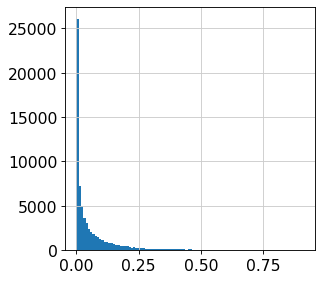

In [85]:
_ = plt.hist(refit_usage_norm['Soup'], bins=100)

In [86]:
adata_with_mdck.obs['Soup_Usage'] = refit_usage_norm.loc[adata_with_mdck.obs.index, 'Soup']

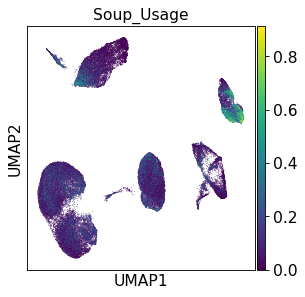

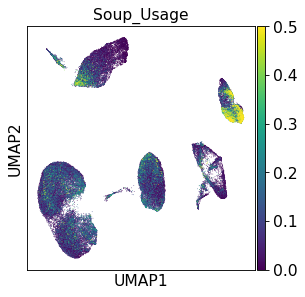

In [87]:
sc.pl.umap(adata_with_mdck, color='Soup_Usage')
sc.pl.umap(adata_with_mdck, color='Soup_Usage', vmax=.5)

## Determine infected cells

In [88]:
soup_profiles = pd.read_csv(soupfn, sep='\t', index_col=0)
soup_profiles.index = [x.split('__')[1] for x in soup_profiles.index]
soup_profiles = soup_profiles.groupby(axis=0, level=0).sum()
soup_profiles = soup_profiles.loc[adata_with_mdck.raw.var.index,:].T

ebovind = [x for x in soup_profiles.columns  if 'EBOV' in x]
soup_profiles_pseduo = (soup_profiles+.1)
ebov_soup_pct = soup_profiles_pseduo.loc[:, ebovind].sum(axis=1) / soup_profiles_pseduo.sum(axis=1)
ebov_soup_pct = dict(ebov_soup_pct)
ebov_soup_pct

{'NHP13.D000.fresh.a1.DASH1-std_88_NovaNext_Merged': 1.7418565929467028e-05,
 'NHP13.D003.FRZ-MDCK.a4.std_88_Novaseq_20190701': 1.0815001623940087e-05,
 'NHP13.D003.FRZ-MDCK.a5.std_88_Novaseq_20190701': 1.3563282643793804e-05,
 'NHP13.D003.FRZ-MDCK.a6.std_88_Novaseq_20190701': 2.5500684046334363e-05,
 'NHP13.D003.FRZ.a1.std_88_Novaseq_20190701': 3.724895098632448e-05,
 'NHP13.D003.FRZ.a2.std_88_Novaseq_20190701': 7.902858068620514e-06,
 'NHP13.D003.FRZ.a3.std_88_Novaseq_20190701': 1.5607496436613472e-06,
 'NHP13.D003.fresh.a1.DASH-std_88_NovaNext_Merged': 5.026905885388306e-07,
 'NHP14.D000.FRZ-MDCK.a1.DASH-std_88_NovaNext_Merged': 9.816875995185803e-07,
 'NHP14.D000.FRZ.a1.DASH-std_88_NovaNext_Merged': 2.4380354054067935e-05,
 'NHP14.D000.FRZ.a2.DASH1_88_Novaseq_20190530': 1.8342389123696946e-06,
 'NHP14.D000.fresh.a1.std_88_Novaseq_20190129': 4.337388563356462e-06,
 'NHP14.D003.FRZ-MDCK.a4.std_88_Novaseq_20190711': 5.2149004428960804e-05,
 'NHP14.D003.FRZ-MDCK.a5.std_88_Novaseq_20190

In [89]:
adata_with_mdck

AnnData object with n_obs × n_vars = 69590 × 1866 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Usage_1', 'Usage_2', 'Usage_3', 'Usage_4', 'Usage_5', 'Usage_6', 'Usage_7', 'Usage_8', 'Usage_9', 'Usage_10', 'Usage_11', 'Usage_12', 'Usage_13', 'Usage_14', 'Usage_15', 'Usage_16', 'Usage_17', 'Usage_18', 'Usage_19', 'Usage_20', 'Soup_Usage'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_

In [90]:
adata_with_mdck

AnnData object with n_obs × n_vars = 69590 × 1866 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Usage_1', 'Usage_2', 'Usage_3', 'Usage_4', 'Usage_5', 'Usage_6', 'Usage_7', 'Usage_8', 'Usage_9', 'Usage_10', 'Usage_11', 'Usage_12', 'Usage_13', 'Usage_14', 'Usage_15', 'Usage_16', 'Usage_17', 'Usage_18', 'Usage_19', 'Usage_20', 'Soup_Usage'
    var: 'full_id', 'gene_symbol', 'gene_id', 'human_ortholog_id', 'human_ortholog_

In [91]:
from scipy.stats import binom
adata_raw.obs['pEBOV_Soup1'] = np.nan
for array in ebov_soup_pct.keys():
    ind = adata_with_mdck.obs['batch']==array
    ind = ind.index[ind]
    N = adata_with_mdck.obs.loc[ind, 'n_counts']
    Nebov = adata_with_mdck.obs.loc[ind, 'EBOV_counts']
    pEBOV_Soup1 = 1-binom.cdf(Nebov-1, p=ebov_soup_pct[array], n=N)
    adata_with_mdck.obs.loc[ind, 'pEBOV_Soup1'] = pEBOV_Soup1

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [92]:
adata_with_mdck.obs.loc[:, 'logEBOV_Soup1'] = -1*(adata_with_mdck.obs.loc[:, 'pEBOV_Soup1']+(10**-10)).apply(np.log10)

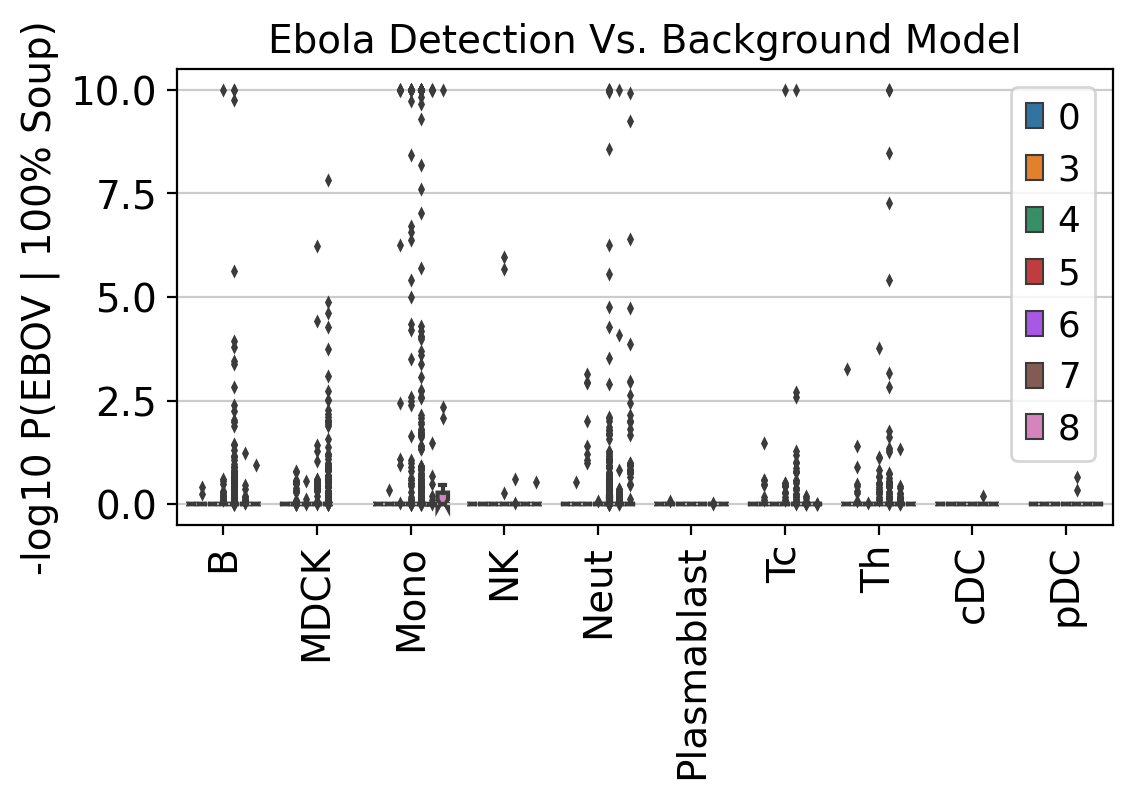

In [93]:
(fig,ax) = plt.subplots(1,1, figsize=(6,3), dpi=200)
hue_order = ['0', '3', '4', '5', '6', '7', '8']
sns.boxplot(x='Subclustering_reduced', y='logEBOV_Soup1', hue='DPIc',
            data=adata_with_mdck.obs, ax=ax, fliersize=2, notch=True, whis=.95,
            hue_order=hue_order)
ax.legend(bbox_to_anchor=(1.,1))
ax.set_ylabel('-log10 P(EBOV | 100% Soup)')
ax.set_xlabel('')
ax.set_title('Ebola Detection Vs. Background Model')
_ = ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()], rotation=90)

In [94]:
adata_with_mdck

AnnData object with n_obs × n_vars = 69590 × 1866 
    obs: 'batch', 'DPI', 'DPIc', 'Period', 'full_sample_id', 'frz_status', 'sample_source', 'sample', 'array_num', 'array_id', 'animal', 'full_dash_status', 'dash_status', 'sample_dash', 'Barcode', 'BP', 'FullSeqRun', 'n_counts', 'n_genes', 'log_count', 'batch_short', 'PCT_USABLE_BASES', 'PCT_MRNA_BASES', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'percent_mito', 'PCT_UNUSABLE_BASES', 'percent_ribo', 'percent_hbb', 'leiden', 'leiden_lab_orig', 'leiden_lab_orig_group', 'leiden_lab_2', 'leiden_lab_group_2', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'Subclustering_reduced', 'Usage_1', 'Usage_2', 'Usage_3', 'Usage_4', 'Usage_5', 'Usage_6', 'Usage_7', 'Usage_8', 'Usage_9', 'Usage_10', 'Usage_11', 'Usage_12', 'Usage_13', 'Usage_14', 'Usage_15', 'Usage_16', 'Usage_17', 'Usage_18', 'Usage_19', 'Usage_20', 'Soup_Usage', 'pEBOV_Soup1', 'logEBOV_Soup1'
    var: 'full_id', 'gene_symbol', 'gene_id', 'huma

In [95]:
ebov_soup_pct_allcells = adata_with_mdck.obs['batch'].apply(lambda x: ebov_soup_pct[x]).astype(float)
null_exp_ebola_from_soup = ebov_soup_pct_allcells * adata_with_mdck.obs['Soup_Usage']
a_thresh = .01
thresh = (binom.isf(a_thresh, p=null_exp_ebola_from_soup, n=adata_with_mdck.obs['n_counts'])+1).astype(int)            
adata_with_mdck.obs['ebola_infection_threshold'] = thresh
adata_with_mdck.obs['Ebola_Positive'] = adata_with_mdck.obs['EBOV_counts']>adata_with_mdck.obs['ebola_infection_threshold']

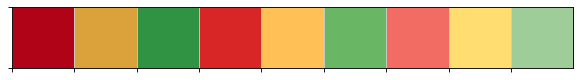

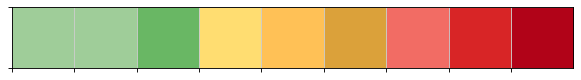

In [96]:
dpi_colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(dpi_colors)
sns.palplot(dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], dpi_colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]

In [97]:
pd.crosstab(adata_with_mdck.obs['Subclustering_reduced'], adata_with_mdck.obs['DPIc'])

DPIc,0,3,4,5,6,7,8
Subclustering_reduced,,,,,,,
B,1951,2848,962,1726,5922,89,7
MDCK,1195,5426,1435,975,3630,0,0
Mono,736,3603,292,715,1562,53,15
NK,577,123,36,111,383,2,12
Neut,10,371,1396,256,2718,240,814
Plasmablast,42,53,8,15,115,17,16
Tc,1933,2163,238,2257,3474,51,166
Th,2855,4613,642,2741,7050,257,16
cDC,73,189,4,19,59,1,0


In [98]:
adata_with_mdck.obs['DPIc2'] = adata_with_mdck.obs['DPIc'].replace({'7':'7-8', '8':'7-8'})

In [99]:
pd.crosstab(adata_with_mdck.obs['Subclustering_reduced'], adata_with_mdck.obs['DPIc2'])

DPIc2,0,3,4,5,6,7-8
Subclustering_reduced,,,,,,
B,1951,2848,962,1726,5922,96
MDCK,1195,5426,1435,975,3630,0
Mono,736,3603,292,715,1562,68
NK,577,123,36,111,383,14
Neut,10,371,1396,256,2718,1054
Plasmablast,42,53,8,15,115,33
Tc,1933,2163,238,2257,3474,217
Th,2855,4613,642,2741,7050,273
cDC,73,189,4,19,59,1


In [100]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [101]:
dpimap2 = {'0': (0.42745098039215684, 0.8, 0.8549019607843137),
 '1': np.array([0.62352941, 0.80392157, 0.6       ]),
 '2': np.array([0.41176471, 0.71764706, 0.39215686]),
 '3': np.array([1.        , 0.86666667, 0.44313725]),
 '4': np.array([1.        , 0.75686275, 0.3372549 ]),
 '5': np.array([0.85882353, 0.63137255, 0.22745098]),
 '6': np.array([0.94901961, 0.42352941, 0.39215686]),
 '7-8': np.array([0.69411765, 0.01176471, 0.09411765])}

In [102]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .17
right_space = .98
bottom_space = .17
top_space = .98

In [103]:
X = adata_with_mdck.obs[['Ebola_Positive', 'Subclustering_reduced', 'DPIc2']]
X['Subclustering_celltype'] = X['Subclustering_reduced'].replace({'cDC':'DC', 'pDC':'DC', 'Tc':'T', 'Th':'T'})
X['Ebola_Positive_100'] = X['Ebola_Positive'].astype(int)*100
X = X.loc[X['Subclustering_celltype']!='Plasmablast', :]

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [104]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


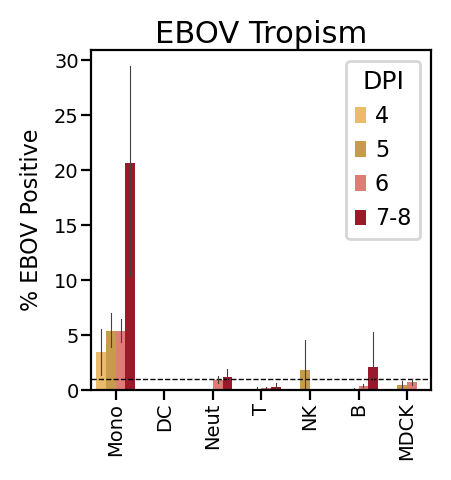

In [105]:
a_thresh = 1
cset = palettable.tableau.GreenOrange_12.hex_colors

ax_width = box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=200)
gs = gridspec.GridSpec(2, 1, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1],
          xscale='linear', yscale='linear',
          frameon=True)

title_ax = fig.add_subplot(gs[0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[],yticks=[],
          xlim=[0,1],
          ylim=[0,1])

error_kw=dict(lw=.7, capsize=.7, capthick=.5)


ct_order = ['Mono', 'DC', 'Neut', 'T', 'NK', 'B', 'MDCK']
hue_order = ['4', '5', '6', '7-8']
sns.barplot(x='Subclustering_celltype', y='Ebola_Positive_100', hue='DPIc2',
           order=ct_order, hue_order=hue_order, palette=dpimap2,
            ax=ax, data=X, errwidth=.4)

ax.set_xticklabels(ct_order, rotation=90)

ax.set_ylabel('% EBOV Positive', fontsize=8)
ax.set_xlabel('', fontsize=8)
ax.set_xticklabels(ct_order, rotation=90)
ax.grid(False)

title_ax.text(0.50, 1.0, 'EBOV Tropism', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)


leg = ax.legend(loc='upper right', title='DPI', fontsize=8, markerscale=.1)
plt.setp(leg.get_title(),fontsize=9)

xlim = ax.get_xlim()
ax.hlines(a_thresh, xmin=xlim[0], xmax=xlim[1], linestyle='--',linewidth=.5)
ax.set_xlim(xlim)

figure_file = os.path.join(results_dir, "EbolaTropism.InVivo.Barplot.pdf")
fig.savefig(figure_file, dpi=300)


In [106]:
invivoebovfn = os.path.join(adir, name+'.EBOVINFOwithMDCK.tsv')
print(invivoebovfn)

../../../../data/InVivo/Seqwell/cNMF.invivo_all_20200318_mmul8_V4_fixid.EBOVINFOwithMDCK.tsv


In [107]:
X = adata_with_mdck.obs[['SubclusteringGroup', 'Subclustering_reduced', 'Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive', 'DPIc2','DPIc', 'frz_status', 'EBOV_counts', 'num_EBOV_genes', 'percent_EBOV', 'EBOV_TPT', 'log10_EBOV_TPT', 'n_counts', 'n_genes', 'log_count', 'batch']]
X.to_csv(invivoebovfn, sep='\t')

In [108]:
for c in ['Soup_Usage', 'ebola_infection_threshold', 'Ebola_Positive']:
    adata_annot.obs[c] = adata_with_mdck.obs.loc[adata_annot.obs.index,c]

In [109]:
processed_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.NoMDCK.NoBOD.Blacklist.HVGs_{nhvgs}.scale.SubclusterMBTNK.UMAP.EBOVcalls.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
save_adata(adata_annot, processed_file, gcs=gcs)

Only considering the two last: ['.EBOVcalls', '.h5ad'].
Only considering the two last: ['.EBOVcalls', '.h5ad'].


In [110]:
full_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.MDCKandPBMC.EBOVestimates.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))

In [111]:
save_adata(adata_with_mdck, full_file, gcs=gcs)

Only considering the two last: ['.EBOVestimates', '.h5ad'].
Only considering the two last: ['.EBOVestimates', '.h5ad'].


... storing 'DPIc2' as categorical


In [112]:
adata_with_mdck = read_adata(full_file, gcs=gcs)

Only considering the two last: ['.EBOVestimates', '.h5ad'].
Only considering the two last: ['.EBOVestimates', '.h5ad'].


In [113]:
from scipy.stats import binom, norm
import sys

def get_sensitivity_convolution(thresh, p1, n1, p2, n2):
    a1 = binom.pmf(np.arange(0, thresh), n=n1, p=p1)
    a2 = binom.pmf(np.arange(0, thresh), n=n2, p=p2)   
    return(1 - np.convolve(a1,a2)[:thresh].sum())


assumed_percent_ebov = [.001, .01]
soup_pcts = [.01, .1, .5]
specificity_thresholds = list(np.logspace(-5, -1, num=30, base=10)) + list(np.linspace(.12, 1, num=30))

sensitivity_vs_spec_approx = pd.DataFrame(index=specificity_thresholds, columns = [(x,y) for x in assumed_percent_ebov for y in soup_pcts])
sensitivity_vs_spec_approx[(.001, 'emperical')] = np.nan
sensitivity_vs_spec_approx[(.01, 'emperical')] = np.nan
#sensitivity_vs_spec_approx[(.001, 'emperical X 2')] = np.nan
#sensitivity_vs_spec_approx[(.01, 'emperical X 2')] = np.nan

np.random.seed(10)
nsample=2000
ind = X['DPIc']!='0'
subsample = X.loc[ind,:].sample(nsample, replace=False).index

N = X.loc[:, 'n_counts'].astype(int)
ebov_soup_pct_allcells = X['batch'].apply(lambda x: ebov_soup_pct[x]).astype(float)
Nsubset = N.loc[subsample]
ebov_soup_pct_subset = ebov_soup_pct_allcells.loc[subsample]

for epct in assumed_percent_ebov:
    for soup_percentage in soup_pcts:
        soup_est_counts = np.round(Nsubset*soup_percentage).astype(int).values
        cell_est_counts = (Nsubset-soup_est_counts).astype(int).values
        #mean = Nsubset*soup_percentage*ebov_soup_pct_subset + Nsubset*(1-soup_percentage)*epct
        #var = (Nsubset*soup_percentage*ebov_soup_pct_subset*(1-ebov_soup_pct_subset)) + (Nsubset*(1-soup_percentage)*epct*(1-epct))
        #sd = var**.5
        
        null_exp_ebola_from_soup = ebov_soup_pct_subset*soup_percentage
        for a in specificity_thresholds:
            print(epct, soup_percentage, a)
            thresh = (binom.isf(a, p=null_exp_ebola_from_soup, n=Nsubset)+1).astype(int)
            prob = []
            for i in range(len(thresh)):
                if thresh[i] > 0:
                    prob.append(get_sensitivity_convolution(thresh[i], epct, cell_est_counts[i],
                                                        ebov_soup_pct_subset[i], soup_est_counts[i]))
                else:
                    prob.append(1)
            
            #prob = norm.sf(thresh, loc=mean, scale=sd)
            sensitivity_vs_spec_approx.at[a, (epct, soup_percentage)] = np.mean(prob)


psoup_emperical = X.loc[Nsubset.index, 'Soup_Usage']
soup_est_counts_emperical = np.round(Nsubset*psoup_emperical).astype(int).values
cell_est_counts_emperical = (Nsubset-soup_est_counts_emperical).astype(int).values
null_exp_ebola_from_soup = psoup_emperical*ebov_soup_pct_subset
for epct in assumed_percent_ebov:
    for a in specificity_thresholds:
        print(epct, 'empirical', a)
        thresh = (binom.isf(a, p=null_exp_ebola_from_soup, n=Nsubset)+1).astype(int)
        prob = []
        for i in range(len(thresh)):
            if thresh[i] > 0:
                prob.append(get_sensitivity_convolution(thresh[i], epct, cell_est_counts_emperical[i],
                                                        ebov_soup_pct_subset[i], soup_est_counts_emperical[i]))
            else:
                prob.append(1)
                
        sensitivity_vs_spec_approx.at[a, (epct, 'emperical')] = np.mean(prob)     

0.001 0.01 1e-05
0.001 0.01 1.3738237958832637e-05
0.001 0.01 1.8873918221350958e-05
0.001 0.01 2.592943797404667e-05
0.001 0.01 3.5622478902624444e-05
0.001 0.01 4.893900918477499e-05
0.001 0.01 6.723357536499335e-05
0.001 0.01 9.236708571873866e-05
0.001 0.01 0.0001268961003167922
0.001 0.01 0.00017433288221999874
0.001 0.01 0.0002395026619987486
0.001 0.01 0.00032903445623126676
0.001 0.01 0.00045203536563602405
0.001 0.01 0.0006210169418915617
0.001 0.01 0.0008531678524172806
0.001 0.01 0.0011721022975334804
0.001 0.01 0.0016102620275609393
0.001 0.01 0.002212216291070448
0.001 0.01 0.0030391953823131978
0.001 0.01 0.0041753189365604
0.001 0.01 0.005736152510448681
0.001 0.01 0.007880462815669913
0.001 0.01 0.01082636733874054
0.001 0.01 0.014873521072935119
0.001 0.01 0.020433597178569417
0.001 0.01 0.028072162039411756
0.001 0.01 0.03856620421163472
0.001 0.01 0.05298316906283707
0.001 0.01 0.07278953843983146
0.001 0.01 0.1
0.001 0.01 0.12
0.001 0.01 0.1503448275862069
0.001 0.0

[Text(0, 0, '0'),
 Text(0, 0, '0.25'),
 Text(0, 0, '0.5'),
 Text(0, 0, '0.75'),
 Text(0, 0, '1.0')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


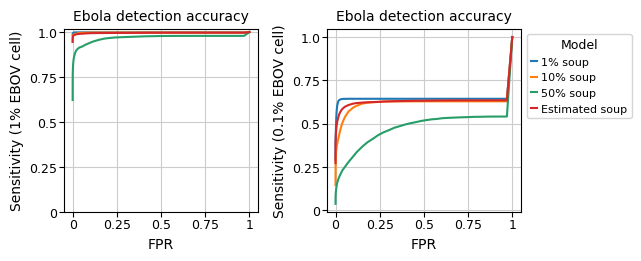

In [114]:
from matplotlib import gridspec
fig = plt.figure(constrained_layout=True, figsize=(6.3, 2.5), dpi=100)
gs = gridspec.GridSpec(1, 2, figure=fig, left=0.3,
                       bottom=.3, right=5, top=2.2, wspace=.3)

#xticks=[], yticks=[], 
ax1 = fig.add_subplot(gs[0], title='Ebola detection accuracy', xlabel='FPR', ylabel='Sensitivity (1% EBOV cell)')
ax2 = fig.add_subplot(gs[1], title='Ebola detection accuracy', xlabel='FPR', ylabel='Sensitivity (.1% EBOV cell)')

lab = ['1% soup', '10% soup', '50% soup', 'Estimated soup']
soup_pct = [.01, .1, .5, 'emperical']

for (i,c) in enumerate(soup_pct):
    ax1.plot(sensitivity_vs_spec_approx.index, sensitivity_vs_spec_approx[(.01, c)], label=lab[i])
    
for (i,c) in enumerate(soup_pct):
    ax2.plot(sensitivity_vs_spec_approx.index, sensitivity_vs_spec_approx[(.001, c)], label=lab[i])

#legend = ax1.legend(loc='lower right', fontsize=8, title='Model')
#plt.setp(legend.get_title(),fontsize=9)

legend = ax2.legend(bbox_to_anchor=(1,1), fontsize=8, title='Model')
plt.setp(legend.get_title(),fontsize=9)

ax1.set_title('Ebola detection accuracy', fontsize=10)
ax1.set_xlabel('FPR', fontsize=10)
ax1.set_ylabel('Sensitivity (1% EBOV cell)', fontsize=10)

ax2.set_title('Ebola detection accuracy', fontsize=10)
ax2.set_xlabel('FPR', fontsize=10)
ax2.set_ylabel('Sensitivity (0.1% EBOV cell)', fontsize=10)

ax1.set_xticks([0, .25, .5, .75, 1])
ax1.set_xticklabels([0, .25, .5, .75, 1], fontsize=9)

ax2.set_xticks([0, .25, .5, .75, 1])
ax2.set_xticklabels([0, .25, .5, .75, 1], fontsize=9)

ax1.set_yticks([0, .25, .5, .75, 1.0])
ax1.set_yticklabels([0, .25, .5, .75, 1.0], fontsize=9)

ax2.set_yticks([0, .25, .5, .75, 1.0])
ax2.set_yticklabels([0, .25, .5, .75, 1.0], fontsize=9)

In [115]:
sensitivity_vs_spec_approx['specificity'] = sensitivity_vs_spec_approx.index

In [116]:
sensitivity_vs_spec_approx.index = np.arange(sensitivity_vs_spec_approx.shape[0])

In [117]:
sensitivity_vs_spec_approx.columns = [str(x).replace('(', 'PctVirus_').replace(', ', '__PctSoup_').replace(')', '').replace("'", '') for x in sensitivity_vs_spec_approx.columns]

In [118]:
roc_fn = os.path.join(adir, name+'.ROCcalculation.tsv')
sensitivity_vs_spec_approx.to_csv(roc_fn, sep='\t')